# Introduction

This is my solution for the [StumbleUpon Evergreen Classification Challenge](https://www.kaggle.com/c/stumbleupon) challenge on Kaggle. In this challange, the task is to predict whether or not a given site is going to be relevant in future. In other words, we are required to predict whether or not a site will be "evergreen". To do this, we are provided with the text in the given url and various other meta-data features. Thus, It is a text classification problem and in this notebook and I have approached it with Feedforward Neural Networks having multiple inputs to handle meta-data and text features seperately.

# Part 1: Exploratory data analysis and data cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option("display.max_columns", None)

In [2]:
train_df = pd.read_csv("../input/stumbleupon/train.tsv", delimiter="\t")
test_df = pd.read_csv("../input/stumbleupon/test.tsv", delimiter="\t")
sub_df = pd.read_csv("../input/stumbleupon/sampleSubmission.csv")

train_df.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0


Seperating **label** from train set.

In [3]:
target = train_df["label"]
train_df.drop(["label"], axis=1, inplace=True)

**urlid** is for giving ID to various rows so dropping from both train and test sets.

In [4]:
train_df.drop(["urlid"], axis=1, inplace=True)
test_df.drop(["urlid"], axis=1, inplace=True)

Extracting the site name from the site URL and changing the column name from **url** to **site_name**.

In [5]:
def get_domain(url):
    temp = url.split("/")
    if temp[0][:4] == "http":
        temp = temp[2]
    else:
        temp = temp[0]

    temp = temp.split(".")
    if temp[0][:3] == "www":
        temp = temp[1]
    else:
        temp = temp[0]

    return temp


train_df["url"] = train_df["url"].apply(get_domain)
test_df["url"] = test_df["url"].apply(get_domain)

train_df.rename(columns={"url": "site_name"}, inplace=True)
test_df.rename(columns={"url": "site_name"}, inplace=True)

There are many sites which occur less than 5 time in the whole dataset. Grouping these site into the "other" category.

In [6]:
from sklearn.impute import SimpleImputer


site = train_df["site_name"].value_counts()
site_map = pd.Series(site.index, index=site.index)

site_map[site < 5] = "other"
del site

train_df["site_name"] = train_df["site_name"].map(site_map)
test_df["site_name"] = test_df["site_name"].map(site_map)
del site_map

test_df["site_name"] = SimpleImputer(strategy="constant", fill_value="other").fit_transform(test_df[["site_name"]])

Imputing missing values in **alchemy_category_score** using SimpleImputer with median strategy.

In [7]:
imputer = SimpleImputer(strategy="median")

train_df["alchemy_category_score"].replace({"?": np.nan}, inplace=True)
test_df["alchemy_category_score"].replace({"?": np.nan}, inplace=True)

train_df["alchemy_category_score"] = train_df["alchemy_category_score"].astype(float)
test_df["alchemy_category_score"] = test_df["alchemy_category_score"].astype(float)

train_df["alchemy_category_score"] = imputer.fit_transform(train_df[["alchemy_category_score"]])
test_df["alchemy_category_score"] = imputer.fit_transform(test_df[["alchemy_category_score"]])

Analyzing the missing value count and dtype of various columns in train and test sets.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   site_name                       7395 non-null   object 
 1   boilerplate                     7395 non-null   object 
 2   alchemy_category                7395 non-null   object 
 3   alchemy_category_score          7395 non-null   float64
 4   avglinksize                     7395 non-null   float64
 5   commonlinkratio_1               7395 non-null   float64
 6   commonlinkratio_2               7395 non-null   float64
 7   commonlinkratio_3               7395 non-null   float64
 8   commonlinkratio_4               7395 non-null   float64
 9   compression_ratio               7395 non-null   float64
 10  embed_ratio                     7395 non-null   float64
 11  framebased                      7395 non-null   int64  
 12  frameTagRatio                   73

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3171 entries, 0 to 3170
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   site_name                       3171 non-null   object 
 1   boilerplate                     3171 non-null   object 
 2   alchemy_category                3171 non-null   object 
 3   alchemy_category_score          3171 non-null   float64
 4   avglinksize                     3171 non-null   float64
 5   commonlinkratio_1               3171 non-null   float64
 6   commonlinkratio_2               3171 non-null   float64
 7   commonlinkratio_3               3171 non-null   float64
 8   commonlinkratio_4               3171 non-null   float64
 9   compression_ratio               3171 non-null   float64
 10  embed_ratio                     3171 non-null   float64
 11  framebased                      3171 non-null   int64  
 12  frameTagRatio                   31

Calculating the number of unique values of various columns in train and test sets.

In [10]:
pd.DataFrame({
    "Train": train_df[test_df.columns].nunique(),
    "Test": test_df.nunique()
})

,Train,Test
site_name,263,228
boilerplate,7394,3171
alchemy_category,14,12
alchemy_category_score,4805,2035
avglinksize,5710,2656
commonlinkratio_1,4476,2228
commonlinkratio_2,4038,2040
commonlinkratio_3,3266,1725
commonlinkratio_4,2695,1381
compression_ratio,6453,2798


**framebased** has 0 variance so dropping it from both train and test sets and also typecasting the dtype of various categorical columns to "object".

In [11]:
train_df.drop(["framebased"], axis=1, inplace=True)
test_df.drop(["framebased"], axis=1, inplace=True)

cat_cols = [
    "site_name",
    "alchemy_category",
    "hasDomainLink",
    "is_news",
    "lengthyLinkDomain",
    "news_front_page",
    "numwords_in_url"
]
cont_cols = list(set(test_df.columns) - set(cat_cols + ["boilerplate"]))

cat_cols = np.array(cat_cols)
cont_cols = np.array(cont_cols)

train_df[cat_cols] = train_df[cat_cols].astype(str)
test_df[cat_cols] = test_df[cat_cols].astype(str)

train_df[cont_cols] = train_df[cont_cols].astype(float)
test_df[cont_cols] = test_df[cont_cols].astype(float)

Some basic statistical parameters for numerical columns in train and test sets.

In [12]:
train_df[cont_cols].describe()

,image_ratio,non_markup_alphanum_characters,frameTagRatio,commonlinkratio_1,commonlinkratio_4,compression_ratio,commonlinkratio_2,linkwordscore,spelling_errors_ratio,html_ratio,parametrizedLinkRatio,numberOfLinks,avglinksize,commonlinkratio_3,alchemy_category_score,embed_ratio
count,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000
mean,0.275709,5716.598242,0.056423,0.468230,0.049262,2.255103,0.214080,30.077079,0.101221,0.233778,0.172864,178.754564,2.761823,0.092062,0.610391,-0.103750
std,1.919320,8875.432430,0.041446,0.203133,0.072629,5.704313,0.146743,20.393101,0.079231,0.052487,0.183286,179.466198,8.619793,0.095978,0.176257,0.306545
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045564,0.000000,1.000000,0.000000,0.000000,0.070833,-1.000000
25%,0.025900,1579.000000,0.028502,0.340370,0.000000,0.442616,0.105263,14.000000,0.068739,0.201061,0.040984,82.000000,1.602062,0.022222,0.538758,0.000000
50%,0.083051,3500.000000,0.045775,0.481481,0.022222,0.483680,0.202454,25.000000,0.089312,0.230564,0.113402,139.000000,2.088235,0.068627,0.625616,0.000000
75%,0.236700,6377.000000,0.073459,0.616604,0.065065,0.578227,0.300000,43.000000,0.112376,0.260770,0.241299,222.000000,2.627451,0.133333,0.708279,0.000000
max,113.333333,207952.000000,0.444444,1.000000,0.980392,21.000000,1.000000,100.000000,1.000000,0.716883,1.000000,4997.000000,363.000000,0.980392,0.999426,0.250000


In [13]:
test_df[cont_cols].describe()

,image_ratio,non_markup_alphanum_characters,frameTagRatio,commonlinkratio_1,commonlinkratio_4,compression_ratio,commonlinkratio_2,linkwordscore,spelling_errors_ratio,html_ratio,parametrizedLinkRatio,numberOfLinks,avglinksize,commonlinkratio_3,alchemy_category_score,embed_ratio
count,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000,3171.000000
mean,0.257211,5698.972564,0.058089,0.467111,0.047845,2.375620,0.207704,29.993693,0.101621,0.235723,0.168745,169.583412,2.968182,0.089960,0.602059,-0.106485
std,1.323941,10726.102405,0.043265,0.199111,0.071556,5.879138,0.144784,20.626985,0.082189,0.054393,0.182017,145.842805,19.536725,0.094182,0.179357,0.311377
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046925,0.000000,1.000000,0.000000,0.000000,0.070833,-1.000000
25%,0.023005,1514.000000,0.028866,0.339454,0.000000,0.441972,0.100000,14.000000,0.067272,0.201739,0.036145,77.000000,1.610350,0.019608,0.533176,0.000000
50%,0.076087,3391.000000,0.048302,0.478261,0.019685,0.481728,0.191919,25.000000,0.088861,0.233212,0.108696,135.000000,2.065476,0.064935,0.616769,0.000000
75%,0.222222,6229.000000,0.074899,0.611270,0.062794,0.586843,0.293978,42.000000,0.112139,0.263529,0.239316,218.500000,2.576541,0.131962,0.693036,0.000000
max,29.000000,331764.000000,0.375000,1.000000,0.696802,21.000000,0.857143,100.000000,1.000000,0.678877,1.000000,1626.000000,1062.000000,0.734932,0.999812,0.928571


Plotting histogram for all the numerical columns in the train set.

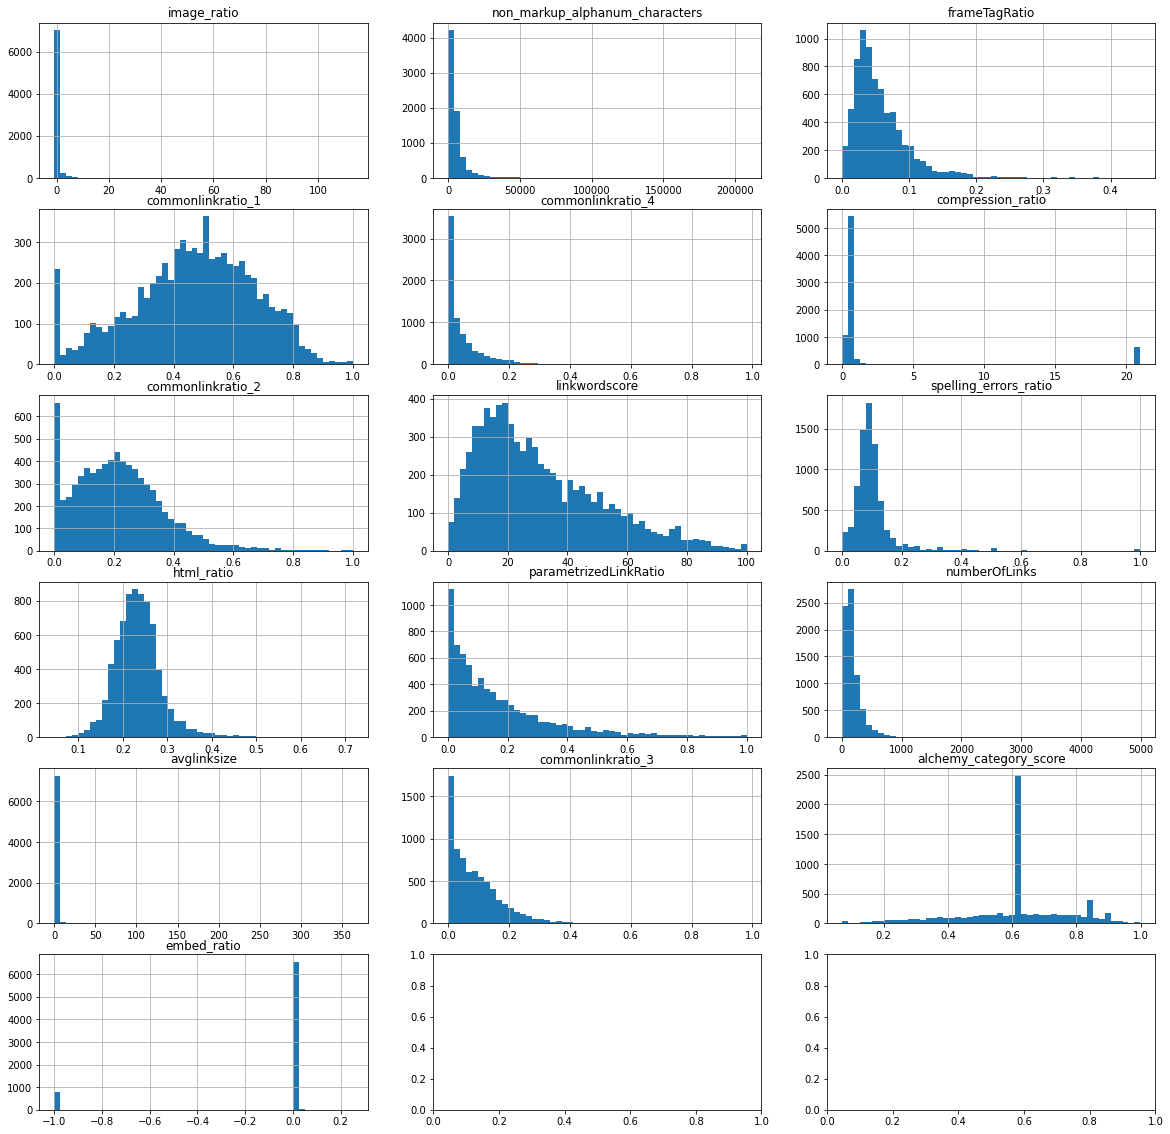

In [14]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20, 20))
ax = np.array(ax).ravel()

for i, col in enumerate(cont_cols):
    ax[i].hist(train_df[col], bins=50)
    ax[i].set_title(col)
    ax[i].grid(True)

fig.show()
fig.savefig("feature_histogram.jpeg")

# Part 2: Feature engineering categorical and text features

**site_name** has very high cardinality so it using the encoding using binary encoding scheme. For all other categorical columns, performing one-hot encoding.

In [15]:
from category_encoders.one_hot import OneHotEncoder
from category_encoders.binary import BinaryEncoder


train_df[["hasDomainLink", "lengthyLinkDomain"]] = train_df[["hasDomainLink", "lengthyLinkDomain"]].astype(int)
test_df[["hasDomainLink", "lengthyLinkDomain"]] = test_df[["hasDomainLink", "lengthyLinkDomain"]].astype(int)

train_df["is_news"].replace({"1": 1, "?": 0}, inplace=True)
test_df["is_news"].replace({"1": 1, "?": 0}, inplace=True)

onehot_enc = OneHotEncoder(cols=["alchemy_category", "news_front_page", "numwords_in_url"])
train_df = onehot_enc.fit_transform(train_df)
test_df = onehot_enc.transform(test_df)

binary_enc = BinaryEncoder(cols=["site_name"])
train_df = binary_enc.fit_transform(train_df)
test_df = binary_enc.fit_transform(test_df)

test_df.insert(0, "site_name_-1", 0)

new_name = {"site_name_"+str(i):"site_name_"+str(i+1) for i in range(-1, 8)}
test_df.rename(columns=new_name, inplace=True)

Cleaning the boilerplate data. Every row is in JSON/Python-dictionary format with keys - *title*, *body* and *url*. Extracting the text from all the keys.

In [16]:
from json import loads


def get_text(bp):
    text_dict = loads(bp)

    text = ""
    for value in text_dict.values():
        if value != None:
            text = text + " " + value

    return text


train_df["boilerplate"] = train_df["boilerplate"].apply(get_text)
test_df["boilerplate"] = test_df["boilerplate"].apply(get_text)

train_df.rename(columns={"boilerplate": "text"}, inplace=True)
test_df.rename(columns={"boilerplate": "text"}, inplace=True)

Removing stopwords, number, punctuations and performing lemmatization using the SpaCy library.

In [17]:
import spacy


def preprocess(df):
    nlp = spacy.load("en_core_web_sm")
    count = 0

    for text in nlp.pipe(df["text"], n_process=4, batch_size=250, disable=["ner", "parser"]):
        df.loc[count, "text"] = " ".join([token.lemma_ for token in text if token.is_alpha and not token.is_stop])
        count += 1

    return df


train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [18]:
train_df.head()

,site_name_0,site_name_1,site_name_2,site_name_3,site_name_4,site_name_5,site_name_6,site_name_7,site_name_8,text,alchemy_category_1,alchemy_category_2,alchemy_category_3,alchemy_category_4,alchemy_category_5,alchemy_category_6,alchemy_category_7,alchemy_category_8,alchemy_category_9,alchemy_category_10,alchemy_category_11,alchemy_category_12,alchemy_category_13,alchemy_category_14,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page_1,news_front_page_2,news_front_page_3,non_markup_alphanum_characters,numberOfLinks,numwords_in_url_1,numwords_in_url_2,numwords_in_url_3,numwords_in_url_4,numwords_in_url_5,numwords_in_url_6,numwords_in_url_7,numwords_in_url_8,numwords_in_url_9,numwords_in_url_10,numwords_in_url_11,numwords_in_url_12,numwords_in_url_13,numwords_in_url_14,numwords_in_url_15,numwords_in_url_16,numwords_in_url_17,numwords_in_url_18,numwords_in_url_19,numwords_in_url_20,numwords_in_url_21,numwords_in_url_22,numwords_in_url_23,parametrizedLinkRatio,spelling_errors_ratio
0,0,0,0,0,0,0,0,0,1,IBM see Holographic Calls Air Breathing Batter...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0.090774,0,0.245831,0.003883,1,1,24.0,1,0,0,5424.0,170.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.152941,0.079130
1,0,0,0,0,0,0,0,1,0,fully electronic Futuristic Starting Gun Elimi...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0.098707,0,0.203490,0.088652,1,1,40.0,1,0,0,4973.0,187.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.181818,0.125448
2,0,0,0,0,0,0,0,1,1,fruit fight Flu fruit fight flu cold flu man h...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0.072448,0,0.226402,0.120536,1,1,55.0,1,0,0,2240.0,258.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166667,0.057613
3,0,0,0,0,0,0,0,0,1,Foolproof Tips Better Sleep period life lot pr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0.095861,0,0.265656,0.035343,1,0,24.0,1,0,0,2737.0,120.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.041667,0.100858
4,0,0,0,0,0,0,1,0,0,Coolest Jerseys Didn t Know exist cool jersey ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0.024908,0,0.228887,0.050473,1,1,14.0,1,0,0,12032.0,162.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.098765,0.082569


Splitting the train dataframe into training and validation sets and then scaling the meta-data features with sklearn RobustScaler.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


train_df, val_df, train_target, val_target = train_test_split(
    train_df,
    target,
    test_size=0.2,
    stratify=target,
    shuffle=True,
    random_state=42
)

train_meta, train_text = train_df.drop(["text"], axis=1), train_df["text"]
del train_df

val_meta, val_text = val_df.drop(["text"], axis=1), val_df["text"]
del val_df

test_meta, test_text = test_df.drop(["text"], axis=1), test_df["text"]
del test_df

scaler = RobustScaler()
train_meta = scaler.fit_transform(train_meta)
val_meta = scaler.transform(val_meta)
test_meta = scaler.transform(test_meta)

# Part 3: Building FNN Model

Analyzing the corpus to find the total number of unique bi-gram tokens maximum sentence length.

In [20]:
from tensorflow.keras.layers import TextVectorization


layer = TextVectorization(ngrams=2)
layer.adapt(train_text)

print("Total number of tokens:", layer.vocabulary_size())
print("Maximum sequence length:", layer(train_text).shape[1])

2022-03-07 16:45:56.188279: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-03-07 16:45:56.319740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Total number of tokens: 901977
Maximum sequence length: 8191


Performing TF-IDF vectorization of the corpus and defining a multi-input neural network model to handle text and meta-data features seperately.

In [21]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.metrics import AUC
from tensorflow.keras import Model
from tensorflow import string


MAX_TOKENS = 900000

text2vec = TextVectorization(
    max_tokens=MAX_TOKENS,
    ngrams=2,
    pad_to_max_tokens=True,
    output_mode="tf_idf"
)
text2vec.adapt(train_text)

text_input = Input(shape=(1,), dtype=string, name="text_input")
x = text2vec(text_input)

meta_input = Input(shape=train_meta.shape[1:], name="meta_input")
y = Concatenate()([x, meta_input])
y = Dense(units=1, activation="sigmoid", name="sigmoid_output")(y)

model = Model(inputs=[text_input, meta_input], outputs=y, name="NLP_Model")

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)

model.summary()

Model: "NLP_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, 900000)       1           text_input[0][0]                 
__________________________________________________________________________________________________
meta_input (InputLayer)         [(None, 68)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 900068)       0           text_vectorization_1[0][0]       
                                                                 meta_input[0][0]         

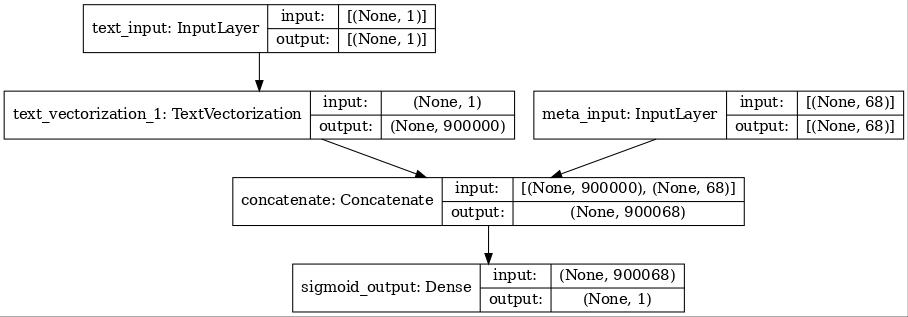

In [22]:
from tensorflow.keras.utils import plot_model


plot_model(
    model=model,
    to_file="fnn_model.jpeg",
    show_shapes=True,
    dpi=75
)

Defining some callbacks for learning rate optimization and early stopping.

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor="val_auc",
    factor=0.2,
    patience=5,
    verbose=True,
    mode="max"
)

early_stop = EarlyStopping(
    monitor="val_auc",
    patience=30,
    verbose=True,
    mode="max",
    restore_best_weights=True
)

callbacks = [reduce_lr, early_stop]

In [24]:
history = model.fit(
    x=[train_text, train_meta],
    y=train_target,
    batch_size=512,
    epochs=300,
    verbose=1,
    callbacks=callbacks,
    validation_data=([val_text, val_meta], val_target),
    shuffle=True
)

Epoch 1/300
12/12 [==============================] - 11s 767ms/step - loss: 0.5819 - accuracy: 0.7527 - auc: 0.8179 - val_loss: 0.8291 - val_accuracy: 0.7566 - val_auc: 0.8148
Epoch 2/300
12/12 [==============================] - 8s 708ms/step - loss: 0.1324 - accuracy: 0.9569 - auc: 0.9947 - val_loss: 1.0633 - val_accuracy: 0.7465 - val_auc: 0.7998
Epoch 3/300
12/12 [==============================] - 8s 716ms/step - loss: 0.0870 - accuracy: 0.9777 - auc: 0.9985 - val_loss: 1.1501 - val_accuracy: 0.7410 - val_auc: 0.7965
Epoch 4/300
12/12 [==============================] - 9s 736ms/step - loss: 0.0679 - accuracy: 0.9936 - auc: 0.9992 - val_loss: 1.1903 - val_accuracy: 0.7417 - val_auc: 0.7973
Epoch 5/300
12/12 [==============================] - 9s 717ms/step - loss: 0.0579 - accuracy: 0.9912 - auc: 0.9994 - val_loss: 1.2426 - val_accuracy: 0.7383 - val_auc: 0.7956
Epoch 6/300
12/12 [==============================] - 8s 709ms/step - loss: 0.0514 - accuracy: 0.9965 - auc: 0.9993 - val_los

In [25]:
model.evaluate([val_text, val_meta], val_target)

47/47 [==============================] - 2s 38ms/step - loss: 0.8291 - accuracy: 0.7566 - auc: 0.8148


[0.8290783166885376, 0.7565922737121582, 0.8148239254951477]

In [26]:
sub_df["label"] = model.predict([test_text, test_meta])
sub_df.to_csv("submission.csv", index=False)

In [27]:
model.save("fnn_model", save_format="tf")

2022-03-07 16:50:56.238938: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Plotting training history of various metrics.

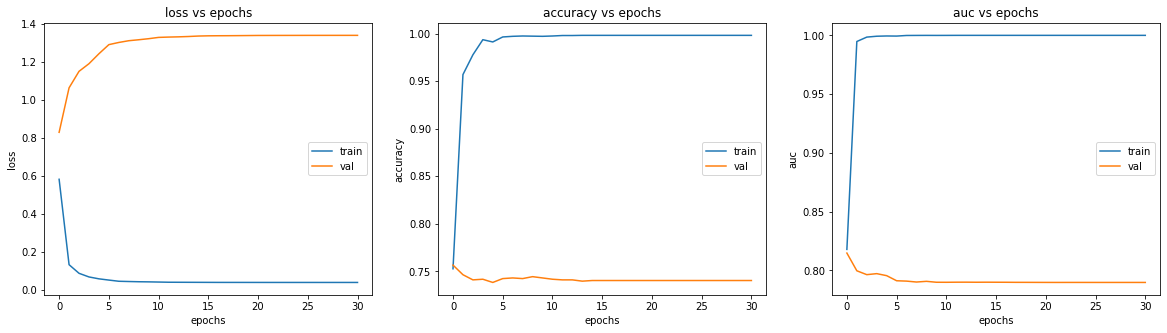

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax = np.array(ax).ravel()

for i, metric in enumerate(["loss", "accuracy", "auc"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].legend(["train", "val"])
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].set_title(metric + " vs epochs")

fig.show()

In [29]:
fig.savefig("fnn_training_history.jpeg")